# Uygulama 5 – SOM ile Kümeleme (Eski SimpSOM Sürümü)
Bu not defterinde, PDF veya resim olarak verilmiş örnek kodlar birleştirilmiştir. Amaç:
1. `airline-safety.csv` verisetini okumak
2. Gereksiz sütunları çıkarmak (örneğin `avail_seat_km_per_week`)
3. 20×20 boyutunda SOM haritası oluşturmak
4. 0.01 öğrenme katsayısıyla 10.000 epok SOM eğitimi
5. Elde edilen 2B koordinatlar üzerinde K-Means ile 3 kümeleme
6. Sonuçları veri çerçevesine ekleyip hangi firmaların hangi kümede olduğuna bakmak

> **Not**: Bu kod, PyPI’de bulunan eski **SimpSOM** yapısına uygundur. Yani `import SimpSOM as sps` ve `sps.somNet(...)` formatını kullanır.

In [12]:
# 1) Gerekli kütüphanelerin eklenmesi
# pip install SimpSOM
# pip install pandas scikit-learn numpy

import pandas as pd
import simpsom as sps
from sklearn.cluster import KMeans
import numpy as np

print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


## 2) Verisetinin Yüklenmesi ve Ön İşlemler
Kodda, resimlerdeki gibi bir yol verilmişti (`C:/Users/burak/Desktop/Uygulama 5.1/airline-safety.csv`). Siz kendi çalışma dizininize göre düzenleyebilirsiniz.
Ardından `airline` ve `avail_seat_km_per_week` sütunlarını düşürürüz.

In [13]:
# Veri seti yolunu düzenleyebilirsiniz:
veri = pd.read_csv("airline-safety.csv")  # Aynı klasördeyse sadece dosya adı yeter

print("Okunan veri seti boyutu:", veri.shape)
display(veri.head())

# Gereksiz sütunları çıkaralım:
X = veri.drop(["airline", "avail_seat_km_per_week"], axis=1)
print("Modelde kullanılacak sütunlar:", X.columns.tolist())

Okunan veri seti boyutu: (56, 8)


,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


Modelde kullanılacak sütunlar: ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99', 'incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']


## 3) SOM Ağı Oluşturma
Resimdeki gibi:
```python
net = sps.somNet(20, 20, X.values, PBC=True)
```
Bu parametreler, 20×20 boyutlu SOM haritası ve periyodik sınır koşullarını etkinleştirir.

In [18]:
net = sps.SOMNet(
    20,         # Genişlik
    20,         # Yükseklik
    X.values,   # NumPy array
    PBC=True    # Periyodik sınırlar
)
print("SOM ağı oluşturuldu.")

Periodic Boundary Conditions active.
The weights will be initialized with PCA.
SOM ağı oluşturuldu.


## 4) Ağın Eğitilmesi
Dokümanda: `net.train(0.01, 10000)` kullanılıyor (0.01 öğrenme oranı, 10000 epok). Bazı sürümlerde `net.train(lr=0.01, ... )` denendiğinde uymaz; bu kütüphanede parametreler sırasıyla girilir.

```python
net.train(learningRate=0.01, epochs=10000)
```
gibi varyasyonlar da görülebilir, ancak orijinal metinde sayısal argüman olarak geçiyor. Aşağıdaki kod birebir resimdeki hale uyarlanmıştır.

In [20]:
# Ağ eğitimi (epok sayısı 10.000, öğrenme katsayısı 0.01)
net.train(train_algo='batch', epochs=10000, start_learning_rate=0.01)
print("SOM eğitimi tamamlandı.")

The map will be trained with the batch algorithm.
Training SOM... done!
SOM eğitimi tamamlandı.


## 5) Verilerin 2 Boyutlu Haritaya Projeksiyonu ve K-Means ile Kümeleme
Resimde şu kod görülüyordu:
```python
hrt = np.array(net.project(X.values))
kmeans = KMeans(n_clusters=3, max_iter=300, random_state=0)
y_kmeans = kmeans.fit_predict(hrt)
```
Böylece her veri noktası (uçak firması) SOM üzerinde 2D koordinatlara yansıtılır (`hrt`). Sonra da 3 kümeli K-Means ile ayrılır.

In [21]:
hrt = np.array(net.project(X.values))
kmeans = KMeans(
    n_clusters=3,  # 3 küme
    max_iter=300,
    random_state=0
)
y_kmeans = kmeans.fit_predict(hrt)
print("Küme etiketleri:", y_kmeans)
print("Toplam örnek sayısı:", len(y_kmeans))

Küme etiketleri: [0 2 0 2 0 1 1 0 0 2 0 1 0 1 0 0 1 0 2 1 1 0 1 0 2 0 0 2 1 1 0 1 0 0 1 2 2
 0 2 0 1 0 2 0 0 2 0 1 0 1 0 1 2 2 0 2]
Toplam örnek sayısı: 56


/Users/atakanemre/.pyenv/versions/3.11.0/lib/python3.11/site-packages/simpsom/network.py:629: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([pos[0]-0.125+random.random()*0.25 for pos in bmu_list],


<Figure size 640x480 with 0 Axes>

## 6) Küme Etiketlerinin Verisetiyle Birleştirilmesi
Resimdeki gibi:
```python
veri["kümeler"] = kmeans.labels_
print(veri[veri["kümeler"]==0].head(5))
...
```
Böylece “0”, “1”, ve “2” kümelerindeki ilk beş satırı görebiliriz. Kümeleri “en iyi firma”, “orta güvenli” vs. şeklinde yorumlayabilirsiniz.

In [22]:
# Verisete küme etiketlerini ekleyelim
veri["kümeler"] = kmeans.labels_

print("#0 numaralı küme (İlk 5 satır)")
display(veri[veri["kümeler"]==0].head(5))

print("\n#1 numaralı küme (İlk 5 satır)")
display(veri[veri["kümeler"]==1].head(5))

print("\n#2 numaralı küme (İlk 5 satır)")
display(veri[veri["kümeler"]==2].head(5))

#0 numaralı küme (İlk 5 satır)


,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14,kümeler
0,Aer Lingus,320906734,2,0,0,0,0,0,0
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0,0
4,Air Canada,1865253802,2,0,0,2,0,0,0
7,Air New Zealand*,710174817,3,0,0,5,1,7,0
8,Alaska Airlines*,965346773,5,0,0,5,1,88,0



#1 numaralı küme (İlk 5 satır)


,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14,kümeler
5,Air France,3004002661,14,4,79,6,2,337,1
6,Air India*,869253552,2,1,329,4,1,158,1
11,American*,5228357340,21,5,101,17,3,416,1
13,Avianca,396922563,5,3,323,0,0,0,1
16,China Airlines,813216487,12,6,535,2,1,225,1



#2 numaralı küme (İlk 5 satır)


,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14,kümeler
1,Aeroflot*,1197672318,76,14,128,6,1,88,2
3,Aeromexico*,596871813,3,1,64,5,0,0,2
9,Alitalia,698012498,7,2,50,4,0,0,2
18,COPA,550491507,3,1,47,0,0,0,2
24,Garuda Indonesia,613356665,10,3,260,4,2,22,2


Sonuçlara göre hangi kümenin "en iyi" (en güvenli) havayolu olduğunu istatistiksel olarak veya kendi kriterlerinize göre seçebilirsiniz.

/Users/atakanemre/.pyenv/versions/3.11.0/lib/python3.11/site-packages/simpsom/network.py:629: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([pos[0]-0.125+random.random()*0.25 for pos in bmu_list],


<Figure size 640x480 with 0 Axes>

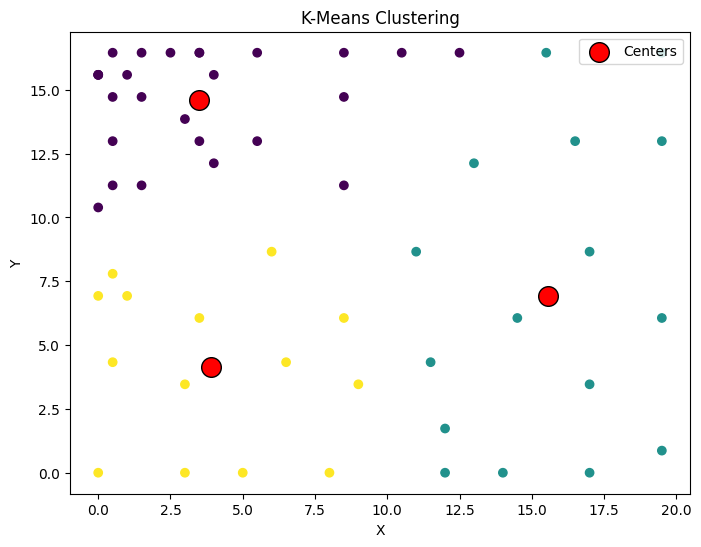

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# net.project(X.values) -> 2 boyutlu koordinatların listesi 
map_coords = np.array(net.project(X.values))  
labels = kmeans.labels_
centers = kmeans.cluster_centers_

plt.figure(figsize=(8,6))
plt.scatter(
    map_coords[:, 0], 
    map_coords[:, 1], 
    c=labels, 
    cmap='viridis'
)
plt.scatter(
    centers[:, 0], 
    centers[:, 1],
    marker='o', 
    s=200, 
    c='red', 
    edgecolor='k', 
    label='Centers'
)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('K-Means Clustering')
plt.legend()
plt.show()